## _Topic Modeling based on Reviews_
***
<b>DESCRIPTION</b>

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon and the topics that customers are talking about. You will perform topic modeling on specific parts of speech. You’ll finally interpret the emerging topics.

<b>Problem Statement: </b>

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

<b>Domain: Amazon reviews for a leading phone brand</b>

- Analysis to be done: POS tagging, topic modeling using LDA, and topic interpretation

<b> Content: </b>

- Dataset: ‘K8 Reviews v0.2.csv’

<b>Columns:</b>
- Sentiment: The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)
- Reviews: The main text of the review

<b>Steps to perform:</b>

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.
Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. Finally, give business-friendly names to the topics and make a table for business.

<b>Tasks: </b>
- Read the .csv file using Pandas. Take a look at the top few records.
- Normalize casings for the review text and extract the text into a list for easier manipulation.
- Tokenize the reviews using NLTKs word_tokenize function.
- Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
- For the topic model, we should  want to include only nouns.
- Find out all the POS tags that correspond to nouns.
- Limit the data to only terms with these tags.
- Lemmatize. 
- Different forms of the terms need to be treated as one.
- No need to provide POS tag to lemmatizer for now.
- Remove stopwords and punctuation (if there are any). 
- Create a topic model using LDA on the cleaned up data with 12 topics.
- Print out the top terms for each topic.
- What is the coherence of the model with the c_v metric?
- Analyze the topics through the business lens.
- Determine which of the topics can be combined.
- Create topic model using LDA with what you think is the optimal number of topics
- What is the coherence of the model?
- The business should  be able to interpret the topics.
- Name each of the identified topics.
- Create a table with the topic name and the top 10 terms in each to present to the  business.



## _Import Libraries and Load the Data_

In [1]:
#data manipulation
import numpy as np
import pandas as pd
import tqdm
#file and system operations
import os
import sys
assert sys.version_info >= (3,5)
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['ytick.labelsize']=12
rcParams['xtick.labelsize']=12
#handle unwanted warnings 
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#view all the columns
pd.options.display.max_columns = None
#basic text manipulation libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

### _Load the Reviews Data_

In [2]:
reviews = pd.read_csv('/kaggle/input/mobile-reviews/K8 Reviews v0.2.csv',delimiter=',',engine='python')
reviews.head(3)

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...


In [3]:
#check the number of reviews 
len(reviews)

14675

In [4]:
#check the basic info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


- _There are no null values or missing values in the dataset_

In [5]:
#check the sentiment labels
reviews['sentiment'].value_counts()

0    7712
1    6963
Name: sentiment, dtype: int64

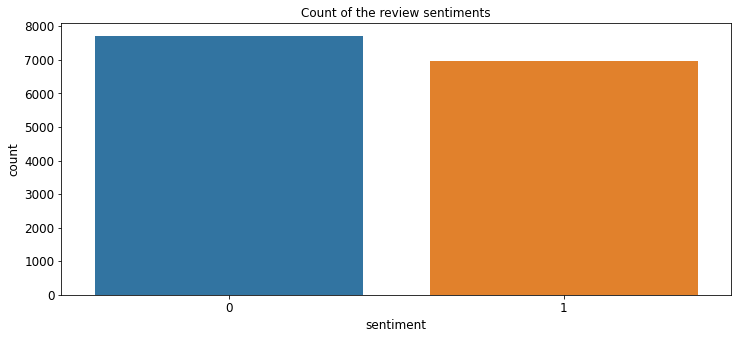

In [6]:
sns.countplot(reviews['sentiment'])
plt.title('Count of the review sentiments')
plt.show()

- _The data seems to be fairly balanced. However, the objective of this project is to do topic modeling and not sentiment classification_

In [7]:
#check randomly any of the reviews
random = np.random.randint(1,len(reviews))
print(reviews['review'][random])

Simply put, "Jack of all trades, Master of None".Battery backup - Below par (this was sad considering 4K mah battery)Heating - Not within acceptable limits, uncomfortable post 15 mins of usage. (got to do with Mediatek processor)Gaming - Below par (Games like subway surfer too with frequent FPS drops & lags, which was really unacceptable, probable because of poor GPU)Dolby Atmos - No real difference when compared to other phonesDesign - Bulky but AppealingDaily use Apps - Glides like its on rails, but with frequent crashing!!!Primary Camera - AverageSelfie Cam - Good


## _Text Preprocessing_
_Following steps will be performed_
- _Tokenization - Split the text into sentences and sentences into words. Lowercase the words and remove any punctuation_
- _Words that are fewer than 3 characters will be removed_
- _All stopwords will be removed_
- _Words are lemmatized - words in third person are changed to first person and words in future and past tense are changed to present tense_
- _Words are stemmed - words are reduced to the root form_

In [8]:
#load the gensim library
import gensim

In [9]:
'''
Write a function to proprocess the entire dataset 
'''
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    '''This function will lemmatize on Noun POS and stem the text'''
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='n'))
    #return (WordNetLemmatizer().lemmatize(text,pos='n'))

#tokenize and lemmatize
def preprocess(text):
    '''Function to break into word tokens, remove stopwords, remove short words and finally to lemmatize and stem the individual tokens'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [10]:
#check for a sample review
result = preprocess('The worst camera I have ever seen. Even my very old configuration mobile phone had a better camera resolution. Battery draining faster.')
print(result)

['worst', 'camera', 'seen', 'configur', 'mobil', 'phone', 'better', 'camera', 'resolut', 'batteri', 'drain', 'faster']


In [11]:
processed_docs = []

#uncomment below line to find the topics for a particular sentiment
#reviews = reviews[reviews['sentiment']==1]

for doc in reviews['review']:
    processed_docs.append(preprocess(doc))

In [12]:
'''
Preview the processed documents
'''
print(processed_docs[:10])

[['good', 'need', 'updat', 'improv'], ['worst', 'mobil', 'bought', 'batteri', 'drain', 'like', 'hell', 'backup', 'hour', 'internet', 'us', 'mobil', 'idl', 'get', 'discharg', 'biggest', 'amazon', 'lenov', 'expect', 'make', 'say', 'batteri', 'booster', 'charger', 'fake', 'take', 'hour', 'fulli', 'charg', 'know', 'lenovo', 'surviv', 'make', 'regret', 'like'], ['cash', 'januari'], ['good'], ['worst', 'phone', 'everthey', 'chang', 'phone', 'problem', 'amazon', 'return', 'phone', 'high', 'disappoint', 'amazon'], ['tell', 'buyi', 'total', 'batterypoor', 'camerawast', 'money'], ['phone', 'awesom', 'charg', 'heat', 'allot', 'genuin', 'reason', 'hate', 'lenovo', 'note'], ['batteri', 'level', 'worn'], ['hit', 'problem', 'phone', 'hang', 'problem', 'lenovo', 'note', 'servic', 'station', 'ahmedabad', 'year', 'warranti', 'chang', 'phone', 'lenovo'], ['glitch', 'dont', 'thing', 'better', 'option']]


## _Bag of Words on the Dataset_

In [13]:
'''
Create a dictionary of the words which appear in the entire corpus
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [14]:
dictionary.keys()[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
#print a few words in the dictionary
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count = count + 1
    if count > 10:
        break

0 good
1 improv
2 need
3 updat
4 amazon
5 backup
6 batteri
7 biggest
8 booster
9 bought
10 charg


### _Gensim filter extremes_
- _Remove or filter the words that appear less than nobelow_
- _Remove or filter the words that apepar more than noabove (fraction)_
- _After the above two steps keep only the n most frequent tokens or keep all_

In [16]:
dictionary.filter_extremes(no_below=5,no_above=0.1,keep_n=None)

### _Gensim doc2bow_
- _Create a bag of words for each document ie for each document we create a dictionary reporting how many words and how many times those words appear_

In [17]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [18]:
bow_corpus[10:20]

[[(57, 1)],
 [(9, 1), (58, 1), (59, 1)],
 [(60, 1), (61, 1), (62, 1), (63, 1)],
 [(29, 1), (35, 2), (59, 1), (61, 1), (64, 1), (65, 1)],
 [(4, 1), (66, 1), (67, 1), (68, 1), (69, 1)],
 [(70, 1), (71, 1)],
 [(72, 1), (73, 1), (74, 1), (75, 1)],
 [(3, 2),
  (7, 1),
  (76, 1),
  (77, 2),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 2),
  (85, 1),
  (86, 1)],
 [(11, 1), (20, 1), (38, 1), (61, 1), (87, 1), (88, 1), (89, 1)],
 [(90, 1)]]

In [19]:
document_num = random
bow_doc_x = bow_corpus[random]

for i in range(len(bow_doc_x)):
    print(f'Word {bow_doc_x[i][0]} {dictionary[bow_doc_x[i][0]]} appears {bow_doc_x[i][1]} times')

Word 4 backup appears 1 times
Word 22 like appears 2 times
Word 62 poor appears 1 times
Word 91 atmo appears 1 times
Word 115 simpli appears 1 times
Word 122 frequent appears 2 times
Word 141 min appears 1 times
Word 160 app appears 1 times
Word 179 usag appears 1 times
Word 208 drop appears 1 times
Word 288 game appears 2 times
Word 293 processor appears 1 times
Word 307 compar appears 1 times
Word 309 dolbi appears 1 times
Word 353 probabl appears 1 times
Word 453 jack appears 1 times
Word 508 crash appears 1 times
Word 519 post appears 1 times
Word 575 differ appears 1 times
Word 636 lag appears 1 times
Word 698 consid appears 1 times
Word 715 mediatek appears 1 times
Word 717 primari appears 1 times
Word 737 real appears 1 times
Word 766 accept appears 1 times
Word 815 limit appears 1 times
Word 865 trade appears 1 times
Word 883 bulki appears 1 times
Word 1536 uncomfort appears 1 times


## _Running LDA using Bag of Words_

In [20]:
#apply the gensim LDA model and generate 12 topics from the corpus
seed = 41
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=12,id2word=dictionary,passes=10,workers=2,
                                      random_state=seed,minimum_probability=0.05,alpha='symmetric')

In [21]:
'''
For each topic, explore each word and its relative weight in the topic
'''

for idx,topic in lda_model.print_topics(-1,num_words=15):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    

Topic: 0 
Words: 0.083*"charg" + 0.064*"charger" + 0.062*"fast" + 0.059*"drain" + 0.042*"updat" + 0.041*"great" + 0.039*"turbo" + 0.021*"slow" + 0.020*"month" + 0.020*"time" + 0.018*"life" + 0.017*"receiv" + 0.016*"worst" + 0.016*"long" + 0.014*"get"


Topic: 1 
Words: 0.113*"charg" + 0.044*"poor" + 0.041*"hour" + 0.029*"get" + 0.029*"time" + 0.026*"take" + 0.023*"glass" + 0.023*"drain" + 0.021*"fast" + 0.019*"issu" + 0.017*"screen" + 0.016*"backup" + 0.015*"qualiti" + 0.015*"gorilla" + 0.013*"mark"


Topic: 2 
Words: 0.120*"problem" + 0.075*"issu" + 0.050*"network" + 0.025*"connect" + 0.022*"face" + 0.018*"hang" + 0.017*"time" + 0.016*"call" + 0.015*"signal" + 0.013*"updat" + 0.013*"automat" + 0.013*"get" + 0.012*"restart" + 0.012*"start" + 0.011*"note"


Topic: 3 
Words: 0.059*"amazon" + 0.045*"servic" + 0.039*"return" + 0.030*"replac" + 0.025*"worst" + 0.025*"like" + 0.022*"purchas" + 0.021*"custom" + 0.019*"day" + 0.016*"devic" + 0.015*"want" + 0.014*"defect" + 0.013*"center" + 0.0

In [22]:
#import Coherence model from gensim
from gensim.models import CoherenceModel
#compute coherence score
lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,
                                    coherence='c_v')
coherence_lda = lda_model_coherence.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.6080062054038797


## _Hyperparameter Tuning_
- _Number of topics K_
- _Dirichlet hyperparamater alpha: Document Topic Density_
- _Dirichlet hyperparameter beta: Word-Topic Density_

In [23]:
#define a helper function
def compute_coherence_score(corpus,dictionary,k,a):
    #instantiate the model instance based on k,a and b
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=k,alpha=a,
                                           passes=10,
                                           random_state=seed)
    lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,coherence='c_v')
    return lda_model_coherence.get_coherence()
    

In [24]:
#search for the best alpha and the number of topics --> one with the highest coherence score will be the best hyperparameter
alpha =['symmetric','asymmetric']

for x in alpha:
    print('Coherence Model with alpha = {}'.format(x))
    print('-------------------------------------------')
    print('\n')
    for i in range(5,10):
        score = compute_coherence_score(corpus=bow_corpus,dictionary=dictionary,k=i,a=x)        
        print(f'Coherence score with {i} topics is {score}')
        print('\n')

Coherence Model with alpha = symmetric
-------------------------------------------


Coherence score with 5 topics is 0.6228705548263168


Coherence score with 6 topics is 0.6268329837991741


Coherence score with 7 topics is 0.6027933639811585


Coherence score with 8 topics is 0.5787400939541569


Coherence score with 9 topics is 0.6016156349915794


Coherence Model with alpha = asymmetric
-------------------------------------------


Coherence score with 5 topics is 0.6514538783671764


Coherence score with 6 topics is 0.6481755938811579


Coherence score with 7 topics is 0.6519655361087151


Coherence score with 8 topics is 0.6569641205031185


Coherence score with 9 topics is 0.6636023351084233




In [25]:
'''
Though the model with alpha='asymmetric' and with 12 topics returned the highest coherence score. For the business use and simplicity, max topics of 7
and alpha='asymmetric' as the final model. This also returned a comparable coherence score of 0.6262
'''
lda_model_final = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=7,id2word=dictionary,passes=10,workers=2,alpha='asymmetric')

In [26]:
from pprint import pprint
# Print the Keyword in the 7 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[bow_corpus]

[(0,
  '0.078*"nice" + 0.048*"price" + 0.047*"best" + 0.039*"awesom" + '
  '0.034*"perform" + 0.030*"backup" + 0.026*"excel" + 0.026*"great" + '
  '0.021*"money" + 0.021*"featur"'),
 (1,
  '0.073*"note" + 0.031*"featur" + 0.024*"option" + 0.024*"like" + '
  '0.024*"screen" + 0.023*"better" + 0.020*"record" + 0.017*"avail" + '
  '0.017*"cast" + 0.016*"miss"'),
 (2,
  '0.103*"qualiti" + 0.061*"poor" + 0.050*"sound" + 0.037*"speaker" + '
  '0.029*"expect" + 0.027*"dolbi" + 0.022*"perform" + 0.018*"averag" + '
  '0.016*"earphon" + 0.015*"receiv"'),
 (3,
  '0.091*"problem" + 0.046*"issu" + 0.028*"servic" + 0.021*"amazon" + '
  '0.021*"updat" + 0.020*"return" + 0.019*"hang" + 0.019*"replac" + '
  '0.017*"month" + 0.017*"purchas"'),
 (4,
  '0.064*"worst" + 0.037*"amazon" + 0.031*"network" + 0.022*"issu" + '
  '0.020*"wast" + 0.017*"money" + 0.017*"signal" + 0.016*"call" + 0.014*"time" '
  '+ 0.013*"return"'),
 (5,
  '0.155*"charg" + 0.047*"charger" + 0.041*"hour" + 0.040*"fast" + '
  '0.039*"

## _Topic Classification_

- _Topic 1: Nice performance for the budget (all the good reviews)_
- _Topic 2: Problems with battery charge and drain_
- _Topic 3: Poor quality of sound and video_
- _Topic 4: Reliiability issues very early since bought_
- _Topic 5: Connectivity Issues_ 
- _Topic 6: Poor customer and replacement service_
- _Topic 7: Quality and Reliability Issues like phone hangs_ 